<a href="https://colab.research.google.com/github/huGgW/Style-Transfer-FLYAI/blob/colab_temp/styletransfer_sw_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EE488 Machine Learning Basics and Practices Project 2**



# **Part 1.** Implement the Batchnormalization Layer in Convolutional Neural Network

## Objective
1. Implementing the batchnormalization layer that can be used like nn.```BatchNorm2d()``` module
2. Understading how to introduce and apply the learnable rescaling and reshifting parameters to the normlized input
3. Comparing the difference between the results with and without the batchnormalization layer




In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np 
import random
import time 
import os

torch.backends.cudnn.deterministic = True # Use cudnn as deterministic mode for reproducibility
torch.backends.cudnn.benchmark = False




## Step1: Load CIFAR-10
- Load **CIFAR-10** dataset using `torchvision` package
- For training data, we utilize appropriate **data augmentation** and **data preprocessing**
  - We utilize **Random Crop** and **Random Horizontal Filp** for data augmentation
  - Data is preprocessed by **normalizing** the data using the mean (0.4914, 0.4822, 0.4465 for each of RGB channel, respectively) and standard deviation (0.2023, 0.1994, 0.2010 for each of RGB channel, respectively) computed from training set of CIFAR-10.
- For test data, we utilize only **data preprocessing**, not **data augmentation**



In [ ]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4), # Random Crop: Randomly crop the part of the large image and utilize it as an augmented data 
        transforms.RandomHorizontalFlip(), # Random Horizontal Flip: Randomly flip the image and utilize it as an augmented data
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]), # Normalize the data using the given mean and standard deviation
        ])

#Apply data preprocessing for test set
transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ]) 

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)  

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


- Implement `reset_seed` function for reproducibility
  - `reset_seed` function sets the random seed for `torch`, `numpy` and `random` pacakges.

In [ ]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

## Step2: Run VGG without Batchnorm.


- Run the experiment without batchnorm for the baseline.
- VGG network is a CNN architecture that developed to understand the effect of network depth on performance.
- The figure below is the architecture of VGG network in this experiment.


## **TODO** : Fill in the blanks of the codes in step 2 and write your own description of the source code in your report. (You can refer to the practice session material for a few blanks)





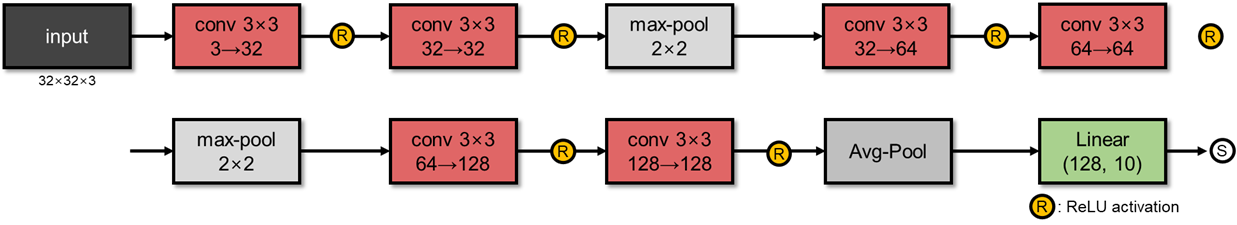

**Step2-1**: Implement VGG network

In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # Convolutional layer with 3x3 kernel. The size of feature does not change due to the usage of padding.
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size 
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) #Note that average pooling layer is not adopted in original VGG architecture. We use average pooling layer to make the architecture for experiment simple.

        self.fc = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        ########################### blank ###########################
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        
        
        #############################################################

        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

**Step2-2**: Implement `train` function for training (see step 2-4 below to see how we are going to use train function) 

In [ ]:
def train(model, data_loader, criterion, optimizer, n_epoch):
    model.train()
    for epoch in range(n_epoch):
        running_loss = 0
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.cuda(), labels.cuda()
            ########################### blank ###########################
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(input=outputs, target=labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        
            #############################################################
            
        print('Epoch {}, loss = {:.3f}'.format(epoch + 1, running_loss/len(data_loader)))

**Step2-3**: Implement `eval` function for evaluation (see step 2-5 below to see how we are going to use eval function)


In [ ]:
def eval(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()
            ########################### blank ###########################
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
        
        
            #############################################################
        accuracy = 100*correct/total
        
    print('Test Accuracy: {}%'.format(accuracy))

**Step2-4**: Train the defined VGG model using `train` function.

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
vgg_model = VGG().to("cuda")
optimizer = optim.Adam(params=vgg_model.parameters())

train(vgg_model, train_loader, criterion, optimizer, n_epoch=10)

Epoch 1, loss = 1.754
Epoch 2, loss = 1.343
Epoch 3, loss = 1.113


KeyboardInterrupt: ignored

**Step2-5**: Check the result (We will compare it with later result)


In [ ]:
eval(vgg_model, test_loader)

Test Accuracy: 78.01%


## Step 3: Implement MyBacthNorm2d() class inheriting nn.Module

When you implement the batchnorm layer in this project, you can inherit the ```nn.Module``` to leave the complicated backward calculations to autograd in pytorch and focus only on implementing the pseudocode of the algorithm in lecture note. In other words, you only need to implement the forward pass of batchnorm layer here. The followings are required to do:

- Consider the moving averages of minibatch mean and variance for inference time handling

- Compute moving averages using  **exponential moving average*** 

- Consider the case of training and inference seperately (using ```self.training``` attribute in ```nn.Module```)

- $\alpha$ for exponential moving averaging should set to be 0.1 (see wikipedia below)

- Implement it so that it can be used like:

```python
self.norm_layer1 = MyBatchNorm2d(output_num_channel)
```

- **Initialize $\gamma$ as 1's**

- **Initialize $\beta$ as 0's**

*see https://en.wikipedia.org/wiki/Moving_average

## **TODO** : Fill in the blanks of the codes in step 3 and write your own description of the source code in your report. (You can refer to the practice session material for a few blanks)

In [ ]:
class MyBatchNorm2d(nn.Module):
    def __init__(self, input_size = None , epsilon = 1e-3, alpha = 0.1):
        super(MyBatchNorm2d, self).__init__()
        self.gamma = nn.Parameter(torch.ones(1, input_size)) # register the tensor as a parameter in this module (be treated like module's parameter -> can be learned via optimizer altogether)
        self.beta = nn.Parameter(torch.zeros(1, input_size)) 
       
        ########################### blank ###########################
        # Batch mean & var must be defined during training
        self.mu = torch.zeros(1, input_size)
        self.var = torch.ones(1, input_size)
        
        # For numerical stability
        self.epsilon = epsilon
        
        # Exponential moving average for mu & var update 
        self.it_call = 0  # training iterations
        self.alpha = alpha # EMA smoothing
        
        # Batch size on which the normalization is computed
        self.batch_size = 0
        
        #############################################################
        
    def forward(self, input):
        self.it_call += 1
        ########################### blank ###########################
        if self.training:         # set to be True automatically when 'model.train()'' is called
              if( self.batch_size == 0 ):
                  # First iteration : save batch_size
                  self.batch_size = x.shape[0]
              
              # Training : compute BN pass
              batch_mu = (x.sum(dim=0)/x.shape[0]).unsqueeze(0) # [1, input_size]
              batch_var = (x.var(dim=0)/x.shape[0]).unsqueeze(0) # [1, input_size]
              
              x_normalized = (x-batch_mu)/torch.sqrt(batch_var + self.epsilon) # [batch_size, input_size]
              output = self.gamma * x_normalized + self.beta # [batch_size, input_size]
              
              
              # Update mu & std 
              if(x.shape[0] == self.batch_size):
                  running_mu = batch_mu
                  running_var = batch_var
              else:
                  running_mu = batch_mu*self.batch_size/x.shape[0]
                  running_var = batch_var*self.batch_size/x.shape[0]
  
              self.mu = running_mu * (self.alpha/self.it_call) + \
                              self.mu * (1 - (self.alpha/self.it_call))
              self.var = running_var * (self.alpha/self.it_call) + \
                          self.var * (1 - (self.alpha/self.it_call))
        
        
        else:                     # if the 'model.eval()' was called
            # Inference : compute BN pass using estimated mu & var
            if (x.shape[0] == self.batch_size):
                estimated_mu = self.mu
                estimated_var = self.var
            else :
                estimated_mu = self.mu*x.shape[0]/self.batch_size
                estimated_var = self.var*x.shape[0]/self.batch_size
                
            x_normalized = (x-estimated_mu)/torch.sqrt(estimated_var + self.epsilon) # [batch_size, input_size]
            output = self.gamma * x_normalized + self.beta # [batch_size, input_size]

        
        #############################################################
        
        return output

## Step4: Implement VGG with MyBatchNorm2d()
We will add MyBatchNorm2d() layer that you made above to VGG.
- Apply the batch normalization between the convolutional layer and activation function.
- VGG have six convolution layers, so you need six batchnorm layers.
- The figure below is the architecture of VGG network with batch normalization.

## **TODO1** : Fill in the blanks of the codes in step 4 and write your own description of the source code in your report. (You can refer to the practice session material for a few blanks)

## **TODO2** : Attach and compare the results of step 2-5 and step 4-3 in your report.

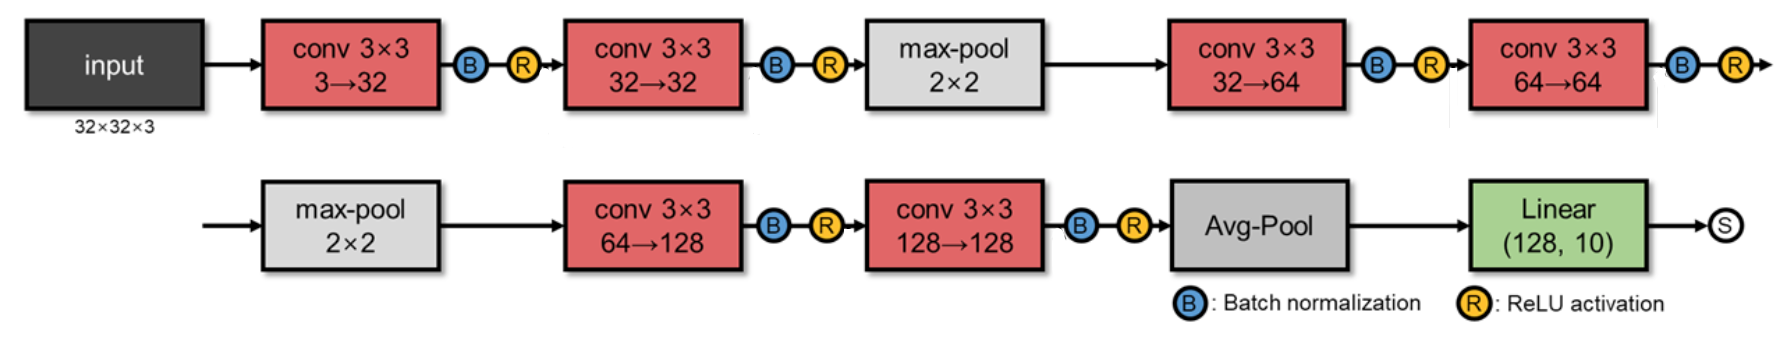

**Step4-1**: Implement `VGG_BatchNorm`

In [ ]:
class VGG_BatchNorm(nn.Module):
    def __init__(self):
        super(VGG_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # Convolutional layer with 3x3 kernel. The size of feature does not change due to the usage of padding.
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.norm4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.norm5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.norm6 = nn.BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size 
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) #Note that average pooling layer is not adopted in original VGG architecture. We use average pooling layer to make the architecture for experiment simple.

        self.fc = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        ########################### blank ###########################
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = self.max_pool(x)

        x = self.conv5(x)
        x = self.norm5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.norm6(x)
        x = F.relu(x)
        
        #############################################################

        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

**Step4-2**: Train the defined `VGG_BatchNorm` model using `train` function.

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
vgg_batchnorm_model = VGG_BatchNorm().to("cuda")
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())

train(vgg_batchnorm_model, train_loader, criterion, optimizer, n_epoch=10)

Epoch 1, loss = 1.307
Epoch 2, loss = 0.910
Epoch 3, loss = 0.765
Epoch 4, loss = 0.669
Epoch 5, loss = 0.607
Epoch 6, loss = 0.563
Epoch 7, loss = 0.524
Epoch 8, loss = 0.494
Epoch 9, loss = 0.467
Epoch 10, loss = 0.447


**Step4-3**: Check the result



In [ ]:
eval(vgg_batchnorm_model, test_loader)

Test Accuracy: 81.89%


# **Part 2.** Neural Style Transfer

## Objective
1. Load content image and style image. Prepare a pre-trained VGG model.
2. Based on the prepared model, compute the content loss and style loss using the content image and style image, respectively.
3. Based on the loss, optimize the image via gradient descent to obtain a style-transfered image.

**Connect google colab with google drive** (copy and paste the authorization code)

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Step 1: Load content image and style image

Load content and style images and plot them.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Make 'EE488/Project2/' folder in your google drive and move all the images to this directory**

In [10]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)
style_img = image_loader("/gdrive/MyDrive/EE488/Project2/candy.jpg")
content_img = image_loader("/gdrive/MyDrive/EE488/Project2/1.jpg")
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


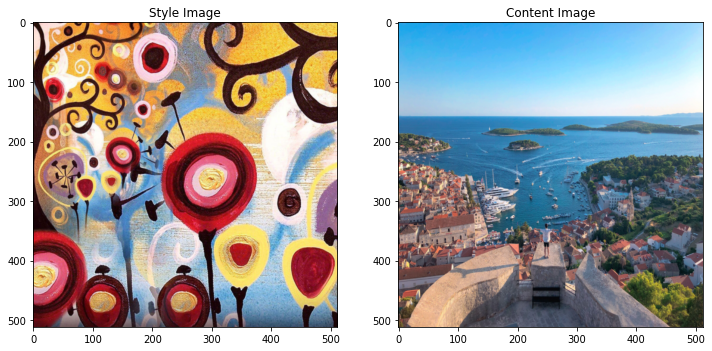

In [11]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 2, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 2, 2)
imshow(content_img, title='Content Image')
plt.show()

## Step 2: Compute style loss and content loss

## **TODO** : Fill in the blanks of the codes in Step 2 and write your own description of the source code in your report.

Here, you first need to split submodules in VGG-11 to construct content loss and style loss. Specifically, you need to store each submodule in a form of "torch.nn.modules.container.Sequential". The "Sequential" module is a container of nn.Module objects. With Sequential containers, you can stack any layer and compose them altogether. First, you should download a pre-trained VGG-11 model.



**Step 2-1:** Prepare a pre-trained VGG-11 model.

In [12]:
cnn = models.vgg19(pretrained=True).features.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

**Step 2-2:** Preparation steps

Note that the pre-trained VGG model is not updated anymore. We only update (adjust) the image. In order to use parameters in VGG11, you need to go through the following preparation steps. First, we need to **change requires_grad to False** for all weights because parameters in VGG11 won't be updated anymore. Second, we should **change in-place operation in all ReLU layers to out-of-place operation**. This is because pytorch cannot perform backpropagation for computation that includes in-place operation.


In [13]:
for name, param in cnn.named_parameters():
    param.requires_grad = False

for layer in cnn:
    if isinstance(layer, nn.ReLU):
      layer.inplace = False

**Step 2-3:** Construct 'content_conv' and 'style_conv'

Pretrained parameters in VGG-11 are contained in two Sequential containers: features and Classifier. The detailed structure of VGG11 and the method of separating the parameters are illustrated in the figure below.
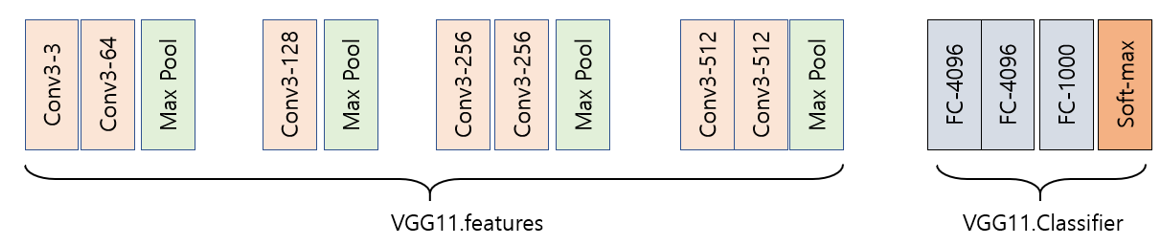

You will use parameters in VGG11.features to construct content loss and style loss.  
As for content loss, you have to create a content convolutional block ('content_conv') by separating few convolutional blocks in the front side of VGG11.features. As for style loss, you have to utilize several small convolutional blocks in VGG11.features to create style convolutional blocks  ('style_conv'). Construct 'content_conv' and 'style_conv' by filling the code below.

**Hint:** Use Slicing

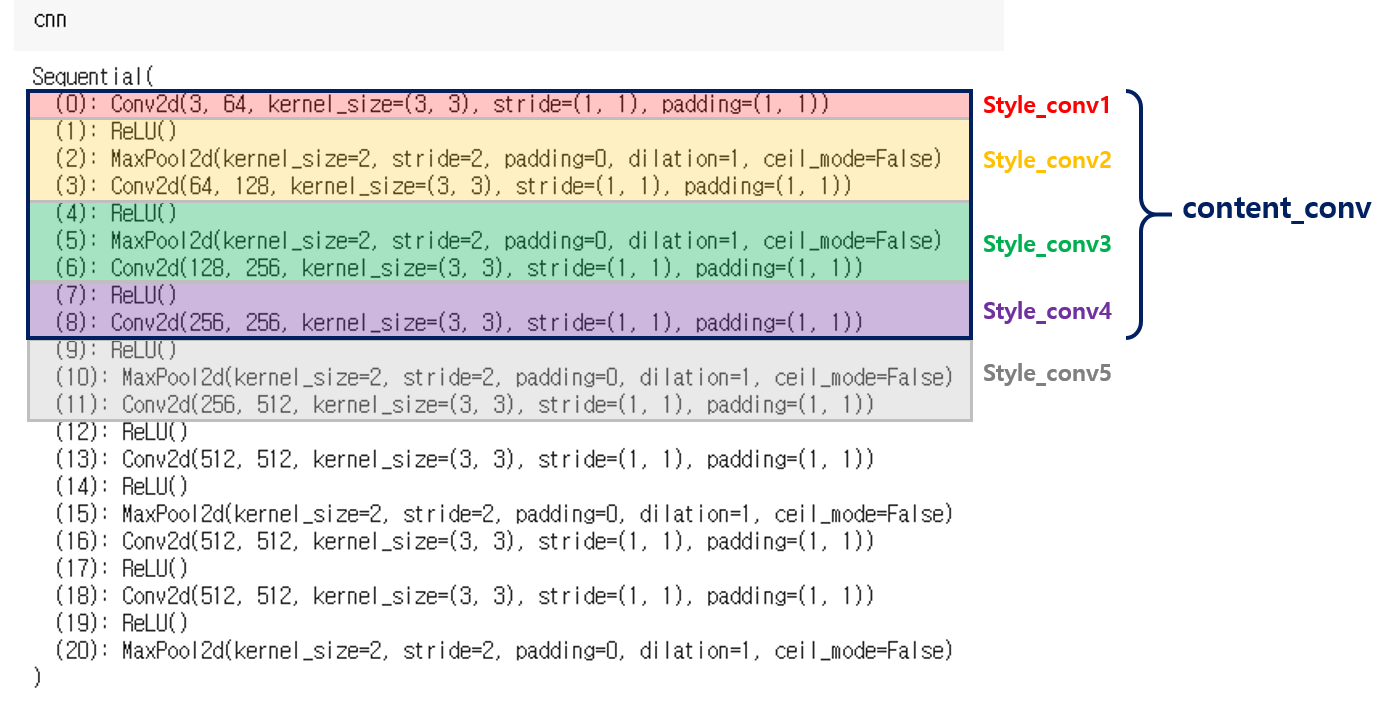

In [14]:
############### blank ###############
style_conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride = 1, padding=1).to(device)
style_conv2 = nn.Sequential(nn.ReLU(),nn.Conv2d(in_channels = 64,
                                      out_channels = 64,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1),nn.ReLU(),
                            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
                            nn.Conv2d(in_channels = 64,
                                      out_channels = 128,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1)
                         ).to(device)
style_conv3 = nn.Sequential(nn.ReLU(), nn.Conv2d(in_channels = 128,
                                      out_channels = 128,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1),nn.ReLU(),
                            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
                            nn.Conv2d(in_channels = 128,
                                      out_channels = 256,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1)
                         ).to(device)
style_conv4 = nn.Sequential(nn.ReLU(),
                            nn.Conv2d(in_channels = 256,
                                      out_channels = 256,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1),nn.ReLU(),
                            nn.Conv2d(in_channels = 256,
                                      out_channels = 256,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1),nn.ReLU(),
                            nn.Conv2d(in_channels = 256,
                                      out_channels = 256,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1),nn.ReLU(),nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
                            nn.Conv2d(in_channels = 256,
                                      out_channels = 512,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1)
).to(device)
style_conv5 = nn.Sequential(nn.ReLU(),
                            nn.Conv2d(in_channels = 512,
                                      out_channels = 512,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1),nn.ReLU(),
                            nn.Conv2d(in_channels = 512,
                                      out_channels = 512,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1),nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1, ceil_mode = False),
                             nn.Conv2d(in_channels = 512,
                                      out_channels = 512,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1)
                  
                            ).to(device)

style_conv6 =  nn.Sequential(nn.ReLU(),
                            nn.Conv2d(in_channels = 512,
                                      out_channels = 512,
                                      kernel_size = 3,
                                      stride = 1,
                                      padding = 1)).to(device)
content_conv = [style_conv1, style_conv2]                            
#####################################

In [15]:
style_convlist = [style_conv1, style_conv2, style_conv3, style_conv4, style_conv6, style_conv5]

**Step 2-4:** Content loss and style loss

Both content/style losses are computed based on mean squared error (mse). We first define 'mse_loss' method as below which computes the mean square error between the input and the target. (returns mse loss)

In [16]:
def mse_loss(input, target):
    ############### blank ###############
    return torch.mean((input - target) ** 2)
    #####################################

In the following we define 'gram_matrix' method, which collects the dot products of vectorized feature maps at a specific layer. (returns gram matrix)

In [17]:
def gram_matrix(feature_map):
    ############### blank ###############
    _, d, h, w = feature_map.size()
    # reshape so we're multiplying the features for each channel
    feature_map = feature_map.view(d, h * w)
    
    # calculate the gram matrix
    G = torch.mm(feature_map, feature_map.t())
    return G
    #####################################

Finally, we define compute_content_loss and compute_style_loss methods. 

**compute_content_loss (returns content loss):** Considering the input (generated image), target (content image) and content_conv, write your own code based on mse_loss method defined above. 

**compute_style_loss (returns style loss):** Considering the input (generated image), target (style image) and style_convlist, write your own code based on gram_matrix and mse_loss methods defined above. (returns style loss)

In [18]:
def compute_content_loss(input, target, content_conv):
    ## Compute the mse-based content loss using content_conv
    ############### blank ###############
    compute_content_loss = 0
    for i in range(len(content_conv)):
        input = content_conv[i](input)
        target = content_conv[i](target)
    compute_content_loss += mse_loss(input, target)
    #####################################
    return compute_content_loss

def compute_style_loss(input, target, style_convlist):
    compute_style_loss = 0
    channels = [64,128,256,256,512,512]
    ## Compute the mse-based style loss using gram_matrix and style_convlist
    ############### blank ###############
    for i in range(len(style_convlist)):
        input = style_convlist[i](input)
        target = style_convlist[i](target)
        S = gram_matrix(input)
        C = gram_matrix(target)
        compute_style_loss += mse_loss(S,C)/(4 * (channels[i] ** 2) * ((imsize * imsize) ** 2))
    return compute_style_loss
    #####################################

## Step 3: Training

Based on the content loss $J^{\text{content}}$ and style loss $J^{\text{style}}$, the overall loss is computed as the following weighted sum
\begin{equation}
J^{\text{total}} = w_c \cdot J^{\text{content}} +   w_s \cdot J^{\text{style}}
\end{equation}
where $w_c$ and $w_s$ correspond to the content weight and style weight, respectively. 

Based on the total loss, update the generated image via gradient descent and backpropagation.

## **TODO** : Fill in the blanks below and write your own description of your source code in the report. Try three different $(w_c, w_s)$ combinations(depeding on your choice) and attach the results in the report. Describe how the output image changes with varying $w_c$ and $w_s$.

In [20]:
input_img = content_img.clone()
optimizer = optim.Adam([input_img.requires_grad_()], lr=0.05)

style_weight = 100000000000      ## style weight w_s
content_weight = 10          ## content weight w_c  
iteration = 2000           

for i in range(iteration):
    
    content_loss = compute_content_loss(input_img, content_img, content_conv)
    style_loss = compute_style_loss(input_img, style_img, style_convlist)
    
    loss = content_weight * content_loss + style_weight * style_loss        
    
    optimizer.zero_grad()                                                      
    loss.backward()                                                            
    optimizer.step()                                                             
    
    if i % 100 == 0:
        print("run [{}]:".format(i))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
            (style_weight * style_loss).item(), (content_weight * content_loss).item()))
        print()
        
input_img.data.clamp_(0, 1)
print('train done')

run [0]:
Style Loss : 8276.250000 Content Loss: 0.000000

run [100]:
Style Loss : 0.602103 Content Loss: 0.002548

run [200]:
Style Loss : 0.065673 Content Loss: 0.002610

run [300]:
Style Loss : 0.038352 Content Loss: 0.002619

run [400]:
Style Loss : 0.024944 Content Loss: 0.002625

run [500]:
Style Loss : 0.017390 Content Loss: 0.002629

run [600]:
Style Loss : 0.012633 Content Loss: 0.002632

run [700]:
Style Loss : 0.009474 Content Loss: 0.002635

run [800]:
Style Loss : 0.007340 Content Loss: 0.002638

run [900]:
Style Loss : 0.005883 Content Loss: 0.002640

run [1000]:
Style Loss : 0.004863 Content Loss: 0.002642

run [1100]:
Style Loss : 0.223962 Content Loss: 0.002633

run [1200]:
Style Loss : 0.003590 Content Loss: 0.002632

run [1300]:
Style Loss : 0.003134 Content Loss: 0.002633

run [1400]:
Style Loss : 0.020536 Content Loss: 0.002622

run [1500]:
Style Loss : 0.002478 Content Loss: 0.002622

run [1600]:
Style Loss : 9.401388 Content Loss: 0.002619

run [1700]:
Style Loss 

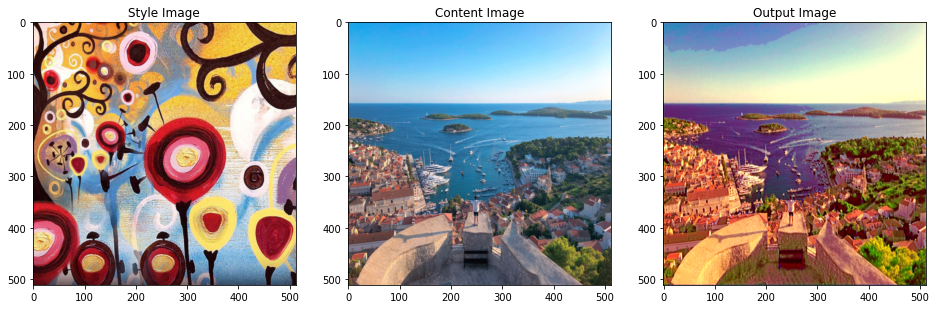

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')
plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')
plt.subplot(1, 3, 3)
imshow(input_img, title='Output Image')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Step 4: Try with another style image

Given a provided content image, perform neural style transfer with another style images (prepared by yourself) and confirm the results

## **TODO** : In the report, show your new style image along with the generated image after neural style transfer.